In [1]:
import numpy as np
import spectrumtools as spt
import matplotlib.pyplot as plt

# Notes

Select a file

data input from  /Users/rogerfearick/Desktop/research/linax/datastore/Pb208/pb208gdr.dat


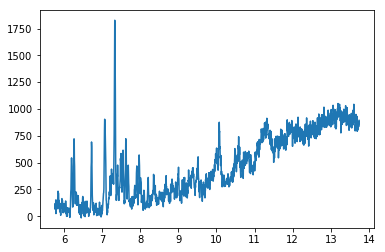

In [2]:
nucleus="208Pb"
xnucleus=nucleus[3:]+nucleus[0:3]  # fiddle name and A !
path=spt.findstore(xnucleus)

angle=0.4
lump=1
targetfilename="pb208gdr.dat"
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800
        
ROIlo=ROIlo+50
ROIhi=ROIhi+50

ROIlo=550
ROIhi=2150
        
# *** Read in data
try:
    print("data input from ",path+targetfilename)
    e,cs0=np.loadtxt(path+targetfilename,unpack=True,usecols=(0,1))
    de=e[2]-e[1]
    # energy in MeV: find kev/ch as int
    intde=int(de*1000.0+0.1)
    G=cs0
    X=e
except:
    raise(ValueError,("File not found"))

plt.plot(e[ROIlo:ROIhi],cs0[ROIlo:ROIhi])
elo=e[ROIlo]
ehi=e[ROIhi]

Peaks between 6..9 MeV are mainly 1- (see Poltarotska thesis)

Create objects

sig=0.0106  sigsm= 0.0372 sigsmn= 0.0125 MeV
Computed bin limits:
 [(0, 200), (40, 240), (80, 280), (120, 320), (160, 360), (200, 400), (240, 440), (280, 480), (320, 520), (360, 560), (400, 600), (440, 640), (480, 680), (520, 720), (560, 760), (600, 800), (640, 840), (680, 880), (720, 920), (760, 960), (800, 1000), (840, 1040), (880, 1080), (920, 1120), (960, 1160), (1000, 1200), (1040, 1240), (1080, 1280), (1120, 1320), (1160, 1360), (1200, 1400), (1240, 1440), (1280, 1480), (1320, 1520), (1360, 1560), (1400, 1600)]


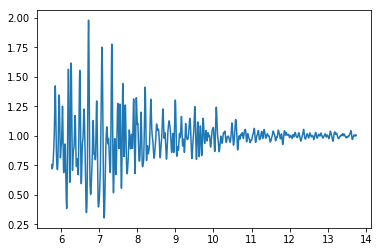

In [3]:
sig = 25.0/2.35/1000.0 # 50 best, at least up to 10 MeV; but Iryna gives 25-30 ??
sigsm=3.5*sig
sigsmn=0.5*2.35*sig #was 0.39
sigx=sigsm*2.5
print("sig=%6.4f  sigsm=%7.4f sigsmn=%7.4f MeV"%(sig,sigsm,sigsmn))

S=spt.RatioSpectrum( X, G, targetfilename, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

bins=spt.ACBinner(S, NAC=8)  # was 8
print("Computed bin limits:\n",bins.get_bins())
plt.plot(S.Eratio,S.rationar)

Select a dataset

Bin limits:    7.152 ..    8.148 MeV


Text(0.8,0.8,'7')

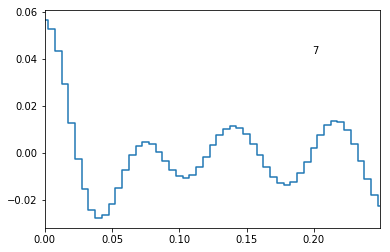

In [4]:
binlist=bins.get_bins()
index=7#17
l,h=binlist[index]
print("Bin limits: %8.3f .. %8.3f MeV"%bins.get_bin_limits(index))
bin=spt.Bin(bins.data,l,h)
energy=bin.Eoffset
data=bin.acnar
plt.plot(energy, data,drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)

(0.0, 0.24875000000000003)

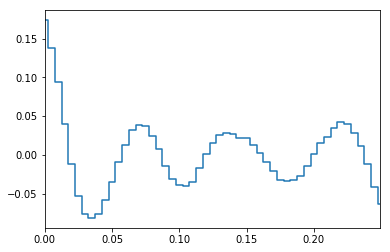

In [5]:
plt.plot(energy,bin.acraw,drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)


Now set up for fits

In [6]:
import lmfit

def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

alpha=2.273
initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
ndata=len(data)
params=lmfit.Parameters()
params.add('D',value=1.0, min=0.0)
params.add('sign',value=np.sqrt(sig**2+sigsmn**2),min=0.0,vary=True)
params.add('sigw',value=np.sqrt(sigsm**2+sig**2),min=0.0,vary=False)
params.add('sigx',value=sigx,vary=False)
theoreticalmodel=model(params,0.0)
params['D'].set(value=initialD)
noise=bin.get_noise_correction(sigsmn, sigsm)
uncert=np.linspace(data[0]/10,data[0]/5,ndata)
ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
#initial=1.0
#popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
#sig=popt[1]
#popt[0]*=initialD
minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                       fcn_kws={'unc':uncert})
result=minner.minimize()
lmfit.printfuncs.report_fit(result.params)

p=result.params.valuesdict()
rho=1.0/p['D']
elo,ehi=bins.get_bin_limits(index)
en=(elo+ehi)/2
print(en,rho,1.0/initialD,p['sigw'],p['sign'],p['sigx'])

[[Variables]]
    D:      0.00246297 +/- 9.12e-05 (3.70%) (init= 0.0009381791)
    sign:   0.01280397 +/- 0.000249 (1.95%) (init= 0.01641412)
    sigw:   0.03872399 (fixed)
    sigx:   0.09308511 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.915 
7.65 406.01255754429474 1065.8946011533812 0.03872398877276871 0.01280397100071795 0.09308510638297872


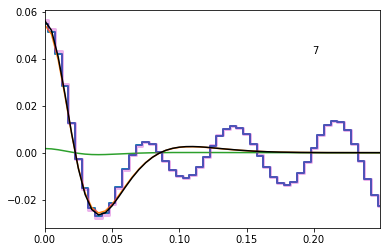

In [7]:
m=model(result.params, energy)
plt.plot(energy, data-noise,lw=2,drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)
plt.plot(energy,m)
plt.plot(energy,noise)
plt.plot(energy,data,'m-',lw=3.0,drawstyle='steps-mid',alpha=0.3)
plt.plot(energy,m+noise,'k-')

Now Bayes

In [8]:
# def function to be used in MC uncertainty analysis (the log likelihood)
def loglike(param, f, data, unc=None):
    #noise=param['noise']
    return -0.5*(np.sum(fitforlm(param,f,data,unc)**2)+np.log(2.0*np.pi*np.sum(unc*unc)))

# MC for parameters: use the log likelihood function.
mcmin = lmfit.Minimizer(loglike, minner.params, fcn_args=(energy, data*np.exp(-energy**2/(2.0*sigx**2))),fcn_kws={'unc':uncert})
res = mcmin.emcee(burn=300, steps=1000, thin=5, params=minner.params, is_weighted=True)
print("done") # takes a while, needs some feedback.

done


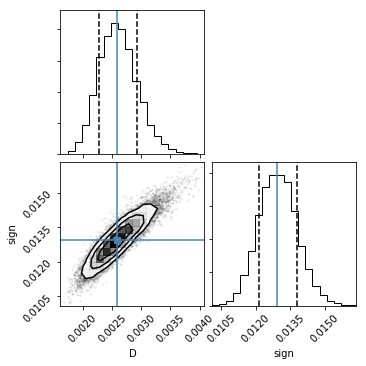

In [9]:
import corner
figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [10]:
quantiles=np.percentile(res.flatchain['D'], [2.28, 97.7])
print("uncertainty: index=",index, "rho=",1.0/quantiles[1],"..",1.0/quantiles[0])

uncertainty: index= 7 rho= 298.6109518723197 .. 497.0975848361802


Group

Note: take-home point: strong correlation (~1.0) between D and sign

In [11]:
rholist=[]
for i,(l,h) in enumerate(binlist):
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    alpha=2.4
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sig,min=0.0)
    params.add('sigw',value=sigsm,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    noise=bin.get_noise_correction(sigsmn, sigsm)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                           fcn_kws={'unc':uncert})
    result=minner.minimize()
    D0=ACfx[0]/theoreticalmodel
    print(i, D0)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    rho=1.0/p['D']
    rho=1.0/D0    # < ========
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    rholist.append((en,rho))

0 0.00811375767396746
[[Variables]]
    D:      0.00964566 +/- 0.000268 (2.78%) (init= 0.001713719)
    sign:   0.01734842 +/- 0.000176 (1.01%) (init= 0.0106383)
    sigw:   0.03723404 (fixed)
    sigx:   0.09308511 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.958 
1 0.0083880435919409
[[Variables]]
    D:      0.01128812 +/- 0.000263 (2.33%) (init= 0.001793722)
    sign:   0.01813698 +/- 0.000145 (0.80%) (init= 0.0106383)
    sigw:   0.03723404 (fixed)
    sigx:   0.09308511 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.962 
2 0.01197496512927118
[[Variables]]
    D:      0.03558128 +/- 0.001623 (4.56%) (init= 0.002482648)
    sign:   0.02248984 +/- 0.000247 (1.10%) (init= 0.0106383)
    sigw:   0.03723404 (fixed)
    sigx:   0.09308511 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.981 
3 0.011757394773184588
[[Variabl

In [12]:
rholist=np.array( rholist )
print(np.shape(rholist))

(36, 2)


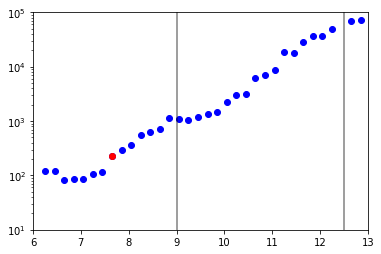

In [13]:
e=rholist.T[0]
rho=rholist.T[1]
plt.semilogy(e,rho,'bo')
plt.semilogy(e[index],rho[index],'ro')
plt.xlim(6.0,13.0)
plt.ylim(1e1,1e5)
#Iryna data on line 9..12.5 MeV
plt.axvline(9.0,color='k',alpha=0.5)
plt.axvline(12.5,color='k',alpha=0.5)